In [25]:
'''
Author: Sriram Yarlagadda + George Nakhleh
Date Created: 10/15/2016
Last Updated: 10/22/2016
Note: Please use Python 2.7
'''
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
#sns.set_palette("colorblind")
#os.chdir('C:\Users\syarlag1\Desktop\Loyola-SAH-Seasonality-Analysis')
#os.chdir('C:\\Users\\gnakhleh\\Documents\\Loyola\\Loyola-SAH-Seasonality-Analysis')

%matplotlib inline

### Reading Data

In [2]:
os.chdir('./data')
dataFiles = os.listdir('.')
allDataDict = {}
# list of variables we need
varList = ['SCORE','SPRING','SUMMER','WINTER','FALL','FEMALE']
for dataFile in dataFiles:
    state = dataFile[-6:-4]
    allDataDict[state] = pd.read_stata(dataFile, columns=varList)

In [3]:
for key in allDataDict.keys(): #creating a new state identifier column
    allDataDict[key]['State'] = pd.Series([str(key)[:2]]*allDataDict[key].shape[0])
allStateData = pd.concat(allDataDict.values()) #combing into a single dataframe

In [4]:
allStateData.index = range(allStateData.shape[0])

### Data Preprocessing

In [5]:
allStateData.shape

(29708, 7)

In [6]:
allStateData.columns

Index([u'SCORE', u'SPRING', u'SUMMER', u'WINTER', u'FALL', u'FEMALE',
       u'State'],
      dtype='object')

In [9]:
#How many records have values less than 0?
np.sum(np.array(allStateData < 0), 0) # 88 values < 0 (invalid)

array([ 0,  0,  0,  0,  0, 88,  0])

In [10]:
#How many null values?
np.sum(np.array(pd.isnull(allStateData)),0) # 226 NaNs

array([  0,   0,   0,   0,   0, 226,   0])

In [11]:
#Drop records with no season (where the sum of the season columns = 0)
for feature in allStateData.columns: 
    allStateData = allStateData[allStateData[feature] >= 0]

In [12]:
# continue with removing instances where all seasons are equal to 0
allStateData = allStateData.drop(allStateData[allStateData['FALL']+\
                                                  allStateData['WINTER']+\
                                                  allStateData['SUMMER']+\
                                                  allStateData['SPRING']== 0].index)

In [13]:
allStateData.shape

(29304, 7)

In [14]:
# creating a new "season" variable
allStateData.index = range(allStateData.shape[0]) # reindexing again to account for the removed rows
season = []
for iRow in range(allStateData.shape[0]):
    if allStateData['FALL'][iRow] == 1: season.append('FALL')
    if allStateData['SPRING'][iRow] == 1: season.append('SPRING')
    if allStateData['SUMMER'][iRow] == 1: season.append('SUMMER')
    if allStateData['WINTER'][iRow] == 1: season.append('WINTER')

allStateData['SEASON'] = pd.Series(season)

In [15]:
# saving an excel copy of the entire data for later use
os.chdir('./..')
allStateData.to_csv('allData.csv') # note that all data only includes the column subsets we need

### Seasonality

#### *Question*: Is there seasonality in the SAH Scores?

Let us first perform some quick data exploration

In [16]:
#count for each season
allStateData.SEASON.value_counts()

SPRING    7497
FALL      7450
WINTER    7390
SUMMER    6967
Name: SEASON, dtype: int64

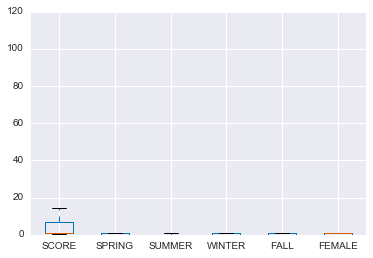

In [24]:
allStateData.plot(kind="box")

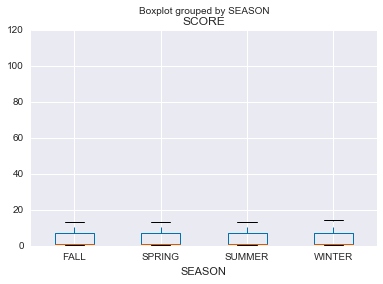

In [26]:
# boxplots of scores for each season
allStateData.boxplot(column='SCORE', by='SEASON')

(0, 20)

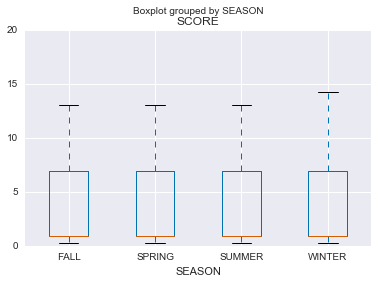

In [27]:
# that's smushed, let's zoom in to where most of the scores are
allStateData.boxplot(column='SCORE', by='SEASON')
plt.ylim(0,20)

Scores appear the same by season, though outliers cloud it a bit

**Analyzing scores**

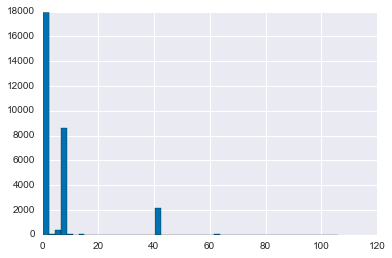

In [32]:
#Distribution of scores, overall
allStateData.SCORE.hist(bins=50)

Let's look at measures of spread of the scores for each season
Standard deviation and range of scores for each season

In [61]:
Fall = allStateData[allStateData['SEASON'] == "FALL"]
Spring = allStateData[allStateData['SEASON'] == "SPRING"]
Summer = allStateData[allStateData['SEASON'] == "SUMMER"]
Winter = allStateData[allStateData['SEASON'] == "WINTER"]

In [99]:
print "MEASURES OF SPREAD\n"
print "Fall: std of SCORE: {},  range: ({}, {})".format(Fall.SCORE.std(), Fall.SCORE.min(), Fall.SCORE.max())
print "Winter: std of SCORE: {},  range: ({}, {})".format(Winter.SCORE.std(), Winter.SCORE.min(), Winter.SCORE.max())
print "Spring: std of SCORE: {},  range: ({}, {})".format(Spring.SCORE.std(), Spring.SCORE.min(), Spring.SCORE.max())
print "Summer: std of SCORE: {},  range: ({}, {})".format(Summer.SCORE.std(), Summer.SCORE.min(), Summer.SCORE.max())
print "Overall: std of SCORE: {},  range: ({}, {})".format(allStateData.SCORE.std(), allStateData.SCORE.min(), allStateData.SCORE.max())


MEASURES OF SPREAD

Fall: std of SCORE: 10.7911522545,  range: (0.29819726944, 63.4340057373)
Winter: std of SCORE: 10.0884504549,  range: (0.29819726944, 106.05947876)
Spring: std of SCORE: 10.2733227625,  range: (0.29819726944, 106.05947876)
Summer: std of SCORE: 10.5475299999,  range: (0.29819726944, 106.05947876)
Overall: std of SCORE: 10.4269728882,  range: (0.29819726944, 106.05947876)


In [100]:
print "Fall: mean of SCORE: {},  median: {}".format(Fall.SCORE.mean(), Fall.SCORE.median())
print "Winter: mean of SCORE: {},  median: {}".format(Winter.SCORE.mean(), Winter.SCORE.median())
print "Spring: mean of SCORE: {},  median: {}".format(Spring.SCORE.mean(), Spring.SCORE.median())
print "Summer: mean of SCORE: {},  median: {}".format(Summer.SCORE.mean(), Summer.SCORE.median())
print "Overall: mean of SCORE: {},  median: {}".format(allStateData.SCORE.mean(), allStateData.SCORE.median())


Fall: mean of SCORE: 6.06922483444,  median: 0.932393848896
Winter: mean of SCORE: 5.63364219666,  median: 0.932393848896
Spring: mean of SCORE: 5.6830291748,  median: 0.932393848896
Summer: mean of SCORE: 5.85928249359,  median: 0.932393848896
Overall: mean of SCORE: 5.81024265289,  median: 0.932393848896


So we see here that the spread is really not that different: across seasons. The maximum values for the seasons isn't really indicative of much, and the boxplots give you a clearer picture of what's going on

In [63]:
#Same data on scores, but as a table of counts
allStateData.SCORE.value_counts().sort_index()

0.298197        467
0.463013          9
0.774142          3
0.932394      17022
1.447735        256
1.750672          3
2.225541        169
2.420563         41
3.455614          1
5.473947        385
6.958751       8607
8.499436          7
10.804901       100
13.065824        46
14.210769         1
18.065428        20
40.853809      2139
63.434006        25
106.059479        3
Name: SCORE, dtype: int64

In [64]:
#Expressed as percent of the overall data
allStateData.SCORE.value_counts().sort_index()/allStateData.shape[0]

0.298197      0.015936
0.463013      0.000307
0.774142      0.000102
0.932394      0.580876
1.447735      0.008736
1.750672      0.000102
2.225541      0.005767
2.420563      0.001399
3.455614      0.000034
5.473947      0.013138
6.958751      0.293714
8.499436      0.000239
10.804901     0.003413
13.065824     0.001570
14.210769     0.000034
18.065428     0.000683
40.853809     0.072993
63.434006     0.000853
106.059479    0.000102
Name: SCORE, dtype: float64

In [65]:
#Expressed as percent of the cumulative sum
#In other words, 59% of the records have a score of 0.93 or less

allStateData.SCORE.value_counts().sort_index().cumsum()/allStateData.shape[0]

0.298197      0.015936
0.463013      0.016244
0.774142      0.016346
0.932394      0.597222
1.447735      0.605958
1.750672      0.606061
2.225541      0.611828
2.420563      0.613227
3.455614      0.613261
5.473947      0.626399
6.958751      0.920113
8.499436      0.920352
10.804901     0.923765
13.065824     0.925334
14.210769     0.925369
18.065428     0.926051
40.853809     0.999044
63.434006     0.999898
106.059479    1.000000
Name: SCORE, dtype: float64

### 1-way ANOVA test
Determining whether there's a meaningful difference in scores by season

In [66]:
# creating seperate tables for each season for later use for anova
FALLData = allStateData[allStateData['SEASON'] == 'FALL']['SCORE']
SUMMERData = allStateData[allStateData['SEASON'] == 'SUMMER']['SCORE']
SPRINGData = allStateData[allStateData['SEASON'] == 'SPRING']['SCORE']
WINTERData = allStateData[allStateData['SEASON'] == 'WINTER']['SCORE']

stats.f_oneway(FALLData, SUMMERData, SPRINGData, WINTERData)

F_onewayResult(statistic=2.6621598986193655, pvalue=0.046311753389164698)

**Analysis of outlier records and w/ outliers removed**  
Outlier defined as a score of greater than 40 (~8% of the data)

In [67]:
allStateData_no_outliers = allStateData[allStateData['SCORE'] < 40]

In [68]:
pd.crosstab(allStateData_no_outliers['SCORE'], allStateData_no_outliers['SEASON'])

SEASON,FALL,SPRING,SUMMER,WINTER
SCORE,,,,
0.298197,105,130,103,129
0.463013,1,2,4,2
0.774142,0,3,0,0
0.932394,4311,4364,4059,4288
1.447735,64,72,56,64
1.750672,1,1,1,0
2.225541,45,45,37,42
2.420563,14,11,9,7
3.455614,0,1,0,0


In [69]:
#Mean scores for each season, with outliers removed
allStateData_no_outliers[['SCORE', 'SEASON']].groupby('SEASON').aggregate(np.mean)

,SCORE
SEASON,
FALL,2.990677
SPRING,2.964716
SUMMER,2.975229
WINTER,3.006950


In [70]:
###Lets look at the spread of the SCORE value by season
Fall_nooutliers = allStateData_no_outliers[allStateData_no_outliers['SEASON'] == "FALL"]
Spring_nooutliers = allStateData_no_outliers[allStateData_no_outliers['SEASON'] == "SPRING"]
Summer_nooutliers = allStateData_no_outliers[allStateData_no_outliers['SEASON'] == "SUMMER"]
Winter_nooutliers = allStateData_no_outliers[allStateData_no_outliers['SEASON'] == "WINTER"]

In [101]:
print "MEASURES OF SPREAD, controlled for outliers\n"
print "Fall: std of SCORE: {},  range: ({}, {})".format(Fall_nooutliers.SCORE.std(), 
                                                        Fall_nooutliers.SCORE.min(), Fall_nooutliers.SCORE.max())
print "Winter: std of SCORE: {},  range: ({}, {})".format(Winter_nooutliers.SCORE.std(),
                                                          Winter_nooutliers.SCORE.min(), Winter_nooutliers.SCORE.max())
print "Spring: std of SCORE: {},  range: ({}, {})".format(Spring_nooutliers.SCORE.std(), 
                                                          Spring_nooutliers.SCORE.min(), Spring_nooutliers.SCORE.max())
print "Summer: std of SCORE: {},  range: ({}, {})".format(Summer_nooutliers.SCORE.std(), 
                                                          Summer_nooutliers.SCORE.min(), Summer_nooutliers.SCORE.max())
print "Overall: std of SCORE: {},  range: ({}, {})".format(allStateData_no_outliers.SCORE.std(), 
                                                           allStateData_no_outliers.SCORE.min(), allStateData_no_outliers.SCORE.max())


MEASURES OF SPREAD, controlled for outliers

Fall: std of SCORE: 2.92786564447,  range: (0.29819726944, 18.0654277802)
Winter: std of SCORE: 2.92592923003,  range: (0.29819726944, 18.0654277802)
Spring: std of SCORE: 2.8881756277,  range: (0.29819726944, 18.0654277802)
Summer: std of SCORE: 2.89957720207,  range: (0.29819726944, 18.0654277802)
Overall: std of SCORE: 2.91073967123,  range: (0.29819726944, 18.0654277802)


In [102]:
print "Fall: mean of SCORE: {},  median: {}".format(Fall_nooutliers.SCORE.mean(), Fall_nooutliers.SCORE.median())
print "Winter: mean of SCORE: {},  median: {}".format(Winter_nooutliers.SCORE.mean(), Winter_nooutliers.SCORE.median())
print "Spring: mean of SCORE: {},  median: {}".format(Spring_nooutliers.SCORE.mean(), Spring_nooutliers.SCORE.median())
print "Summer: mean of SCORE: {},  median: {}".format(Summer_nooutliers.SCORE.mean(), Summer_nooutliers.SCORE.median())
print "Overall: mean of SCORE: {},  median: {}".format(allStateData_no_outliers.SCORE.mean(), allStateData_no_outliers.SCORE.median())


Fall: mean of SCORE: 2.99076414108,  median: 0.932393848896
Winter: mean of SCORE: 3.00704455376,  median: 0.932393848896
Spring: mean of SCORE: 2.96480703354,  median: 0.932393848896
Summer: mean of SCORE: 2.97532105446,  median: 0.932393848896
Overall: mean of SCORE: 2.98455929756,  median: 0.932393848896


SO even with outliers removed, we are seeing that seasons have similar ranges of SAH scores

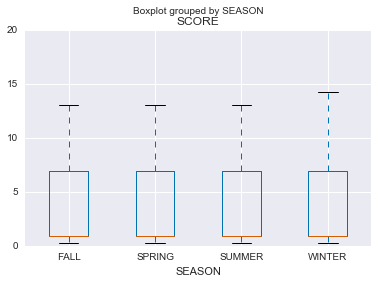

In [74]:
#Boxplot with outliers removed
allStateData_no_outliers.boxplot(column='SCORE', by='SEASON')

Even with outliers removed, the scores don't vary by season

In [75]:
#Analyzing the outliers (defined as a score of more than 40 (about 8% of the records))
allStateData_outliers = allStateData[allStateData['SCORE'] > 40]

allStateData_outliers[['SCORE', 'SEASON']].groupby('SEASON').aggregate(np.mean)

,SCORE
SEASON,
FALL,41.154377
SPRING,41.273483
SUMMER,41.322983
WINTER,41.070213


**State-by-state analysis**  
Looking at same things, to see if any results differ by state

In [76]:
allStateData.columns

Index([u'SCORE', u'SPRING', u'SUMMER', u'WINTER', u'FALL', u'FEMALE', u'State',
       u'SEASON'],
      dtype='object')

In [77]:
allStateData.State.value_counts()

CA    18132
NY     8229
WA     2006
IA      937
Name: State, dtype: int64

In [78]:
#Create state specific dataframes in case we need them
CA_data = allStateData[allStateData['State'] == 'CA']
NY_data = allStateData[allStateData['State'] == 'NY']
WA_data = allStateData[allStateData['State'] == 'WA']
IA_data = allStateData[allStateData['State'] == 'IA']

In [79]:
#Might not actually need those dataframes
#Lets see what we can do just by grouping by state, or iterating over

SAH_groupedbystate = allStateData[['State', 'SPRING', 'SUMMER', 'WINTER', 'FALL','SEASON', 'SCORE']].groupby('State')

#How many records for each season are there, by state
print(SAH_groupedbystate[['SPRING', 'SUMMER', 'WINTER', 'FALL']].aggregate('sum'))  #results are off: exactly the same...

       SPRING  SUMMER  WINTER    FALL
State                                
CA     4679.0  4356.0  4547.0  4550.0
IA      226.0   221.0   242.0   248.0
NY     2097.0  1893.0  2097.0  2142.0
WA      495.0   497.0   504.0   510.0


In [81]:
#Similar breakdowns
print(SAH_groupedbystate[['SPRING', 'SUMMER', 'WINTER', 'FALL']].aggregate('sum').apply(lambda x: x/x.sum(), axis=1))

         SPRING    SUMMER    WINTER      FALL
State                                        
CA     0.258052  0.240238  0.250772  0.250938
IA     0.241195  0.235859  0.258271  0.264674
NY     0.254830  0.230040  0.254830  0.260299
WA     0.246760  0.247757  0.251246  0.254237


In [82]:
SAH_groupedbystate_nooutliers = allStateData_no_outliers[['State', 'SPRING', 'SUMMER', 
                                                      'WINTER', 'FALL','SEASON', 'SCORE']].groupby('State')

print(SAH_groupedbystate_nooutliers['SCORE'].aggregate(np.mean))

State
CA    2.914092
IA    2.895962
NY    3.121237
WA    3.088122
Name: SCORE, dtype: float32


In [98]:
#Ranges of SCORE in each state, overall and not by season
print SAH_groupedbystate_nooutliers['SCORE'].aggregate(np.std)

State
CA    2.873746
IA    2.824230
NY    2.984764
WA    2.942753
Name: SCORE, dtype: float32


Mean scores by state and season

In [83]:
SAH_season_groupedbystateandseason = allStateData[['State', 'SPRING', 'SUMMER', 'WINTER', 
                                                  'FALL','SEASON', 'SCORE']].groupby(['State', 'SEASON'])
print(SAH_season_groupedbystateandseason['SCORE'].aggregate(np.mean))

State  SEASON
CA     FALL      6.217946
       SPRING    5.983382
       SUMMER    5.951336
       WINTER    5.935328
IA     FALL      5.011483
       SPRING    6.586821
       SUMMER    4.953653
       WINTER    4.906367
NY     FALL      5.948319
       SPRING    5.119598
       SUMMER    6.005303
       WINTER    5.184735
WA     FALL      5.766925
       SPRING    4.820359
       SUMMER    4.901056
       WINTER    5.130880
Name: SCORE, dtype: float32


Lets do some measures of spread and center for each state by season (no outliers)

In [84]:
SAH_season_groupedbystateandseason_nooutliers = allStateData_no_outliers[['State', 'SPRING', 'SUMMER', 'WINTER', 
                                                  'FALL','SEASON', 'SCORE']].groupby(['State', 'SEASON'])
print(SAH_season_groupedbystateandseason_nooutliers['SCORE'].aggregate(np.mean))

State  SEASON
CA     FALL      2.923720
       SPRING    2.927763
       SUMMER    2.891549
       WINTER    2.912055
IA     FALL      2.704037
       SPRING    3.332458
       SUMMER    2.709893
       WINTER    2.865683
NY     FALL      3.119127
       SPRING    3.021017
       SUMMER    3.149162
       WINTER    3.198736
WA     FALL      3.181576
       SPRING    2.903686
       SUMMER    3.156513
       WINTER    3.108828
Name: SCORE, dtype: float32


In [103]:
print(SAH_season_groupedbystateandseason_nooutliers['SCORE'].aggregate(np.median))

State  SEASON
CA     FALL      0.932394
       SPRING    0.932394
       SUMMER    0.932394
       WINTER    0.932394
IA     FALL      0.932394
       SPRING    0.932394
       SUMMER    0.932394
       WINTER    0.932394
NY     FALL      0.932394
       SPRING    0.932394
       SUMMER    0.932394
       WINTER    0.932394
WA     FALL      0.932394
       SPRING    0.932394
       SUMMER    0.932394
       WINTER    0.932394
Name: SCORE, dtype: float32


In [104]:
print(SAH_season_groupedbystateandseason_nooutliers['SCORE'].aggregate(np.std))

State  SEASON
CA     FALL      2.894411
       SPRING    2.876615
       SUMMER    2.854378
       WINTER    2.869568
IA     FALL      2.803182
       SPRING    2.939797
       SUMMER    2.736534
       WINTER    2.792760
NY     FALL      2.995414
       SPRING    2.917060
       SUMMER    2.985945
       WINTER    3.038842
WA     FALL      2.970219
       SPRING    2.842329
       SUMMER    2.992363
       WINTER    2.963964
Name: SCORE, dtype: float32


In [108]:
print(SAH_season_groupedbystateandseason_nooutliers['SCORE'].aggregate(np.min))

State  SEASON
CA     FALL      0.298197
       SPRING    0.298197
       SUMMER    0.298197
       WINTER    0.298197
IA     FALL      0.298197
       SPRING    0.298197
       SUMMER    0.298197
       WINTER    0.298197
NY     FALL      0.298197
       SPRING    0.298197
       SUMMER    0.298197
       WINTER    0.298197
WA     FALL      0.298197
       SPRING    0.298197
       SUMMER    0.298197
       WINTER    0.298197
Name: SCORE, dtype: float32


In [107]:
print(SAH_season_groupedbystateandseason_nooutliers['SCORE'].aggregate(np.max))

State  SEASON
CA     FALL      18.065428
       SPRING    18.065428
       SUMMER    18.065428
       WINTER    18.065428
IA     FALL      13.065824
       SPRING     6.958751
       SUMMER     6.958751
       WINTER     6.958751
NY     FALL      18.065428
       SPRING    18.065428
       SUMMER    18.065428
       WINTER    18.065428
WA     FALL      13.065824
       SPRING    10.804901
       SUMMER    18.065428
       WINTER    13.065824
Name: SCORE, dtype: float32


Boxplot: Scores by state and season

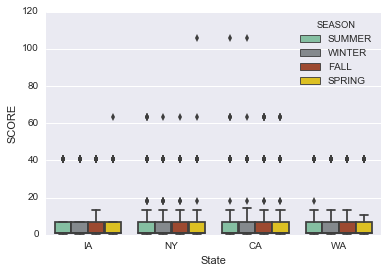

In [85]:
sns.boxplot(x="State", y="SCORE", hue="SEASON", 
            data=allStateData, palette=["#7cc8a2","#82898f", "#af401f", "#fbd504"])

Boxplot: Scores by state and season (no outliers)

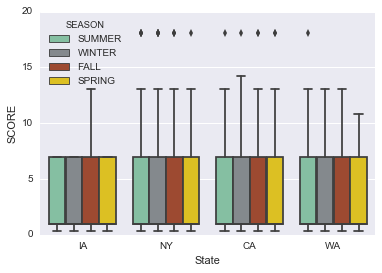

In [86]:
sns.boxplot(x="State", y="SCORE", hue="SEASON", 
            data=allStateData_no_outliers, palette=["#7cc8a2","#82898f", "#af401f", "#fbd504"])

Boxplot of distribution of outlier scores by state and season

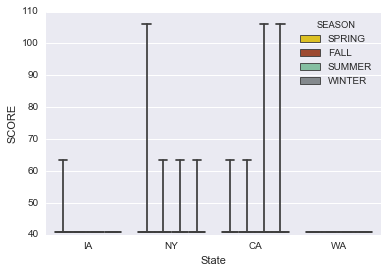

In [87]:
sns.boxplot(x="State", y="SCORE", hue="SEASON", 
            data=allStateData_outliers, palette=["#fbd504", "#af401f", "#7cc8a2","#82898f"])

Boxplot of scores greater or equal to 1 (~40% of the data) by state and season

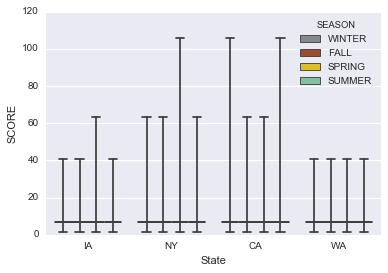

In [88]:
sns.boxplot(x="State", y="SCORE", hue="SEASON", 
            data=allStateData[allStateData['SCORE'] >=1], palette=["#82898f", "#af401f", "#fbd504", "#7cc8a2"])

ANOVA tests state-by-state

In [89]:
# creating seperate tables for each season for later use for anova
def anova_tester(df):
    FALLData = df[df['SEASON'] == 'FALL']['SCORE']
    SUMMERData = df[df['SEASON'] == 'SUMMER']['SCORE']
    SPRINGData = df[df['SEASON'] == 'SPRING']['SCORE']
    WINTERData = df[df['SEASON'] == 'WINTER']['SCORE']

    return stats.f_oneway(FALLData, SUMMERData, SPRINGData, WINTERData)

In [90]:
print "Iowa: ", anova_tester(IA_data)

Iowa:  F_onewayResult(statistic=1.5852062459445773, pvalue=0.19136305406166029)


In [91]:
print "California: ", anova_tester(CA_data)

California:  F_onewayResult(statistic=0.67173184940108599, pvalue=0.5692704760557068)


In [92]:
print "Washington state: ", anova_tester(WA_data)

Washington state:  F_onewayResult(statistic=1.1312500697524432, pvalue=0.33507910398752638)


Only NY state data has a seasonal difference in scores with any significance, but let's look at this data

In [93]:
#The difference in NY scores by season is significant
print "New York: ", anova_tester(NY_data)

New York:  F_onewayResult(statistic=4.8558481684148882, pvalue=0.0022386946135250379)


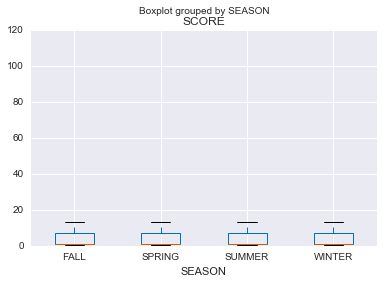

In [94]:
NY_data.boxplot(column="SCORE", by="SEASON")

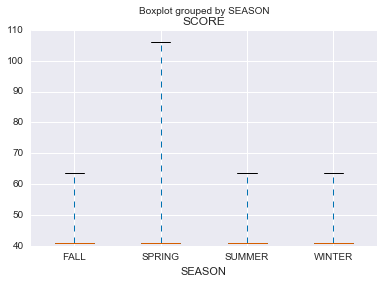

In [95]:
NY_data[NY_data['SCORE'] > 40].boxplot(column="SCORE", by="SEASON")

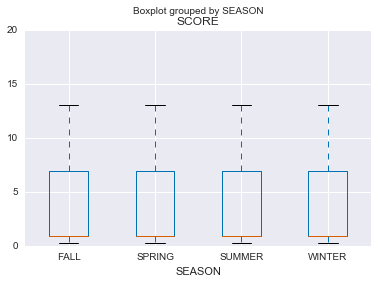

In [96]:
NY_data[NY_data['SCORE'] < 40].boxplot(column="SCORE", by="SEASON")